# Get the data

In [10]:
import os

from skimage import io
import numpy as np

# paths to data
path_closed = "./data/train/Closed_Eyes"
path_open = "./data/train/Open_Eyes"

# list of filenames
closed_eyes_files = os.listdir(path_closed)
open_eyes_files = os.listdir(path_open)

In [11]:
# images stored here
closed_eyes = []
open_eyes = []

# images loaded here
for file_name in closed_eyes_files:
    path = path_closed + "/" + file_name
    closed_eyes.append(io.imread(path))

for file_name in open_eyes_files:
    path = path_open + "/" + file_name
    open_eyes.append(io.imread(path))

# get sizes of the pictures in the array
closed_eyes_sizes = [image.shape[0] for image in closed_eyes]
open_eyes_sizes = [image.shape[0] for image in open_eyes]

# Resize

In [12]:
from skimage.transform import resize


median_size = (np.median(open_eyes_sizes + closed_eyes_sizes))

# resize to target size, equal to mean value for all sizes
target_size = (int(median_size), int(median_size))
open_resized = []
closed_resized = []
 
for img in closed_eyes:
    closed_resized.append(resize(img, target_size, anti_aliasing=True))

for img in open_eyes:
    open_resized.append(resize(img, target_size, anti_aliasing=True))

closed_resized = np.array(closed_resized)
open_resized = np.array(open_resized)


In [13]:

X = np.concatenate((closed_resized, open_resized), axis=0)
y = np.concatenate((np.zeros(2000), np.ones(2000))) # 0 for closed, 1 for open eye

## Splitting into training and test set

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV

# stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

# 4:1
# 3200 in train set, 1600 open 1600 closed
print(X_train.shape)

# SVD

In [14]:
X_flattened = X_train.reshape(3200, -1)

In [15]:
X_centered = X_flattened - X_flattened.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)

In [21]:
from matplotlib import pyplot as plt

c1 = Vt.T[:,0]
c2 = Vt.T[:,1]
c3 = Vt.T[:,2]


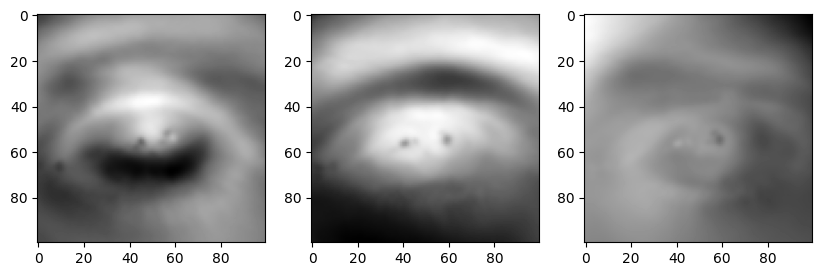

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.imshow(c1.reshape(100,100), cmap="gray")
ax2.imshow(c2.reshape(100,100), cmap="gray")
ax3.imshow(c3.reshape(100,100), cmap="gray")
plt.show()

# PCA

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40) #40 is an arbitrary chosen number at this point
X2D = pca.fit_transform(X_flattened)


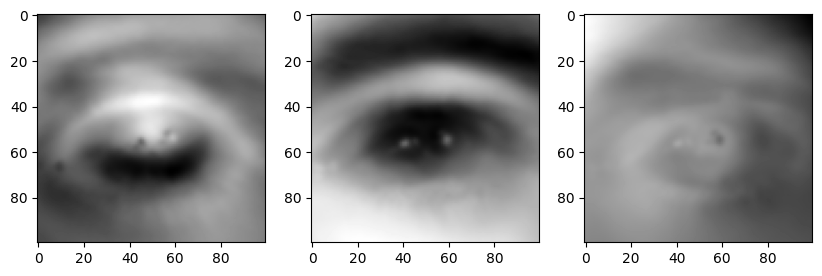

In [26]:
pc1 = pca.components_[0].reshape(100, 100)
pc2 = pca.components_[1].reshape(100, 100)
pc3 = pca.components_[2].reshape(100, 100)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.imshow(pc1, cmap="gray")
ax2.imshow(pc2, cmap="gray")
ax3.imshow(pc3, cmap="gray")
plt.show()

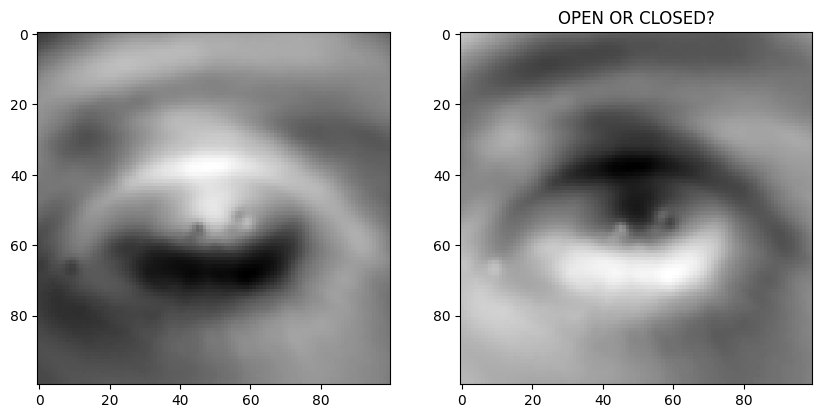

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plt.title("OPEN OR CLOSED?")
ax1.imshow(pc1, cmap="gray")
ax2.imshow(-pc1, cmap="gray")
plt.show()

In [28]:
# how many points of variation it translates
print(pca.explained_variance_ratio_)
explained_variance = sum(pca.explained_variance_ratio_)
print("lost", (1.0 - explained_variance))


[5.74665241e-01 1.33336601e-01 1.01888359e-01 2.97954085e-02
 2.47830886e-02 2.11934234e-02 1.18933421e-02 1.07855721e-02
 9.44525224e-03 6.33691874e-03 5.45983210e-03 4.80694652e-03
 4.60020902e-03 4.10523323e-03 3.30071932e-03 3.17921208e-03
 2.57799772e-03 2.42049999e-03 2.11956215e-03 1.95617369e-03
 1.73098018e-03 1.56273855e-03 1.53403719e-03 1.34847125e-03
 1.26213373e-03 1.17229701e-03 1.12070863e-03 1.08850901e-03
 1.00541494e-03 9.50286115e-04 8.45536754e-04 8.09963182e-04
 7.72495286e-04 7.05211647e-04 6.75157912e-04 6.63984563e-04
 6.44258488e-04 5.97661087e-04 5.86845708e-04 5.34656951e-04]
lost 0.02173905908670115


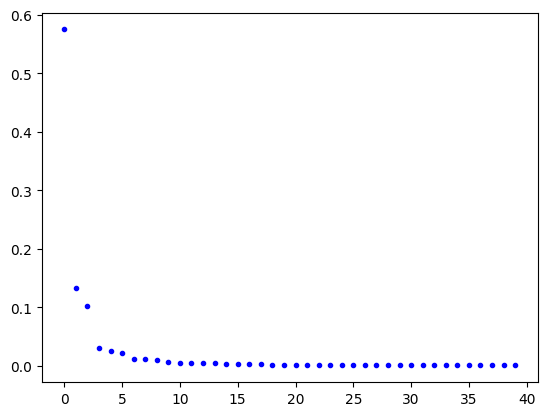

In [29]:
plt.plot(pca.explained_variance_ratio_, '.b')
plt.show()

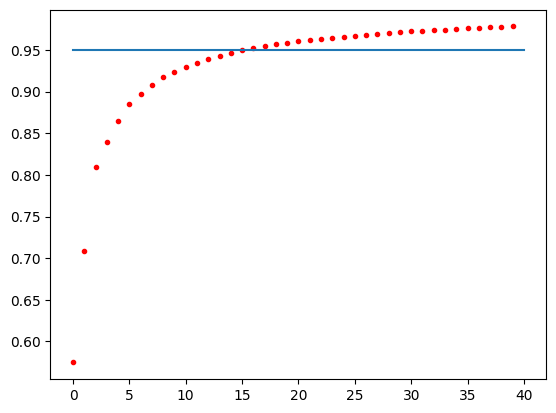

In [30]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.r')
a = np.linspace(0, 40, 100)  # Zakres wartości x od 0 do 10
b = np.full_like(a, 0.95) 
plt.plot(a, b)
plt.show()


In [33]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

# 4:1
# 3200 in train set, 1600 open 1600 closed
